In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [3]:
dataset_path = "/kaggle/input/fer2013plus/fer2013plus/fer2013"  


In [5]:
train_dir = "/kaggle/input/fer2013plus/fer2013plus/fer2013/train"
test_dir = "/kaggle/input/fer2013plus/fer2013plus/fer2013/test"


In [6]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Class labels:", train_generator.class_indices)


Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.
Class labels: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutral': 5, 'sadness': 6, 'surprise': 7}


In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/kaggle/working/emotion_model.keras", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


888/888 ━━━━━━━━━━━━━━━━━━━━ 469s 513ms/step - accuracy: 0.3495 - loss: 1.6229 - val_accuracy: 0.3740 - val_loss: 1.5822
Epoch 2/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 306s 342ms/step - accuracy: 0.3673 - loss: 1.5809 - val_accuracy: 0.3858 - val_loss: 1.5581
Epoch 3/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 300s 335ms/step - accuracy: 0.3743 - loss: 1.5628 - val_accuracy: 0.4105 - val_loss: 1.5451
Epoch 4/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 298s 333ms/step - accuracy: 0.3885 - loss: 1.5446 - val_accuracy: 0.4067 - val_loss: 1.5251
Epoch 5/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 301s 336ms/step - accuracy: 0.3938 - loss: 1.5404 - val_accuracy: 0.4274 - val_loss: 1.5256
Epoch 6/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 305s 341ms/step - accuracy: 0.4060 - loss: 1.5177 - val_accuracy: 0.4292 - val_loss: 1.4947
Epoch 7/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 326s 365ms/step - accuracy: 0.4129 - loss: 1.5011 - val_accuracy: 0.4260 - val_loss: 1.4896
Epoch 8/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 339s 379ms/step - accuracy: 0.4174 - loss: 1.49

In [11]:
val_accuracy_percent = history.history['val_accuracy'][-1] * 100
print(f"Validation Accuracy: {val_accuracy_percent:.2f}%")

test_loss, test_accuracy = model.evaluate(val_generator, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Validation Accuracy: 50.06%
222/222 - 13s - 59ms/step - accuracy: 0.5006 - loss: 1.3885
Test Accuracy: 50.06%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


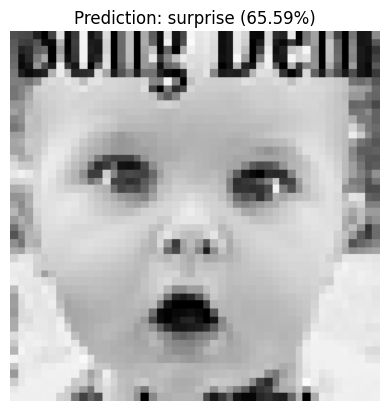

In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to your test image
img_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test/surprise/fer0028659.png'  # <- update this

# 1. Load and resize image in RGB mode
img = image.load_img(img_path, target_size=(224, 224))

# 2. Convert to array
img_array = image.img_to_array(img)

# 3. Normalize and batchify
img_array = img_array / 255.0
img_batch = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)

# 4. Make prediction
predictions = model.predict(img_batch)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# 5. Map class index to label
class_names = list(train_generator.class_indices.keys())

# 6. Show image with prediction
plt.imshow(np.array(img).astype("uint8"))
plt.title(f"Prediction: {class_names[predicted_class]} ({confidence * 100:.2f}%)")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


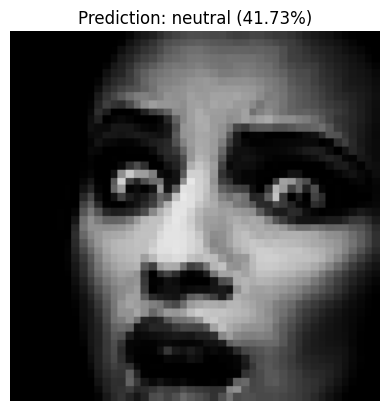

In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to your test image
img_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test/fear/fer0028820.png'  # <- update this

# 1. Load and resize image in RGB mode
img = image.load_img(img_path, target_size=(224, 224))

# 2. Convert to array
img_array = image.img_to_array(img)

# 3. Normalize and batchify
img_array = img_array / 255.0
img_batch = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)

# 4. Make prediction
predictions = model.predict(img_batch)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# 5. Map class index to label
class_names = list(train_generator.class_indices.keys())

# 6. Show image with prediction
plt.imshow(np.array(img).astype("uint8"))
plt.title(f"Prediction: {class_names[predicted_class]} ({confidence * 100:.2f}%)")
plt.axis('off')
plt.show()


In [ ]:
model.save("/kaggle/working/emotion_model_resnet50.h5", save_format="h5")
